In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE 
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier

In [3]:
from sklearn.metrics import classification_report

def report(model, x, y, text = "trening"):
    y_pred = model.predict(x)
    
    print(f'Klasifikacioni izveštaj za model {type(model).__name__} za {text} podatke')
    print("---------------------------------------------------------------------------------")
    print(classification_report(y, y_pred))
    print("---------------------------------------------------------------------------------")
    
    print(f'Matrica konfuzije za model {type(model).__name__}za {text} podatke')
    print("---------------------------------------------------------------------------------")
    print(pd.DataFrame(confusion_matrix(y, y_pred), columns=['0', '1', '-1'], index=['0', '1', '-1']))
    print("---------------------------------------------------------------------------------")
    


In [4]:
X_train = pd.read_csv("../preprocessing/X_train.csv")
y_train = pd.read_csv("../preprocessing/y_train.csv")
X_test = pd.read_csv("../preprocessing/X_test.csv")
y_test = pd.read_csv("../preprocessing/y_test.csv")

In [5]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

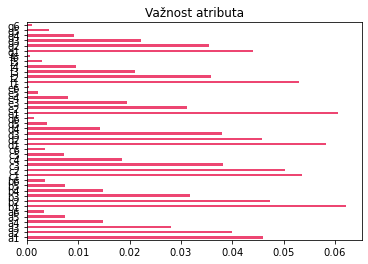

In [6]:
pd.Series(clf.feature_importances_, index=X_train.columns).plot.barh(color='#ED4672')
plt.title("Važnost atributa")
plt.show()

Iz značajnosti stributa vidimo da je mnogo bitnije da li su i kako popunjena polja u dnu table, nego na vrhu, što i ima smisla s obzirom na to kako se igra igra.

In [7]:
report(clf, X_train, y_train)

Klasifikacioni izveštaj za model DecisionTreeClassifier za trening podatke
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     13294
           0       1.00      1.00      1.00      5154
           1       1.00      1.00      1.00     35597

    accuracy                           1.00     54045
   macro avg       1.00      1.00      1.00     54045
weighted avg       1.00      1.00      1.00     54045

---------------------------------------------------------------------------------
Matrica konfuzije za model DecisionTreeClassifierza trening podatke
---------------------------------------------------------------------------------
        0     1     -1
0   13294     0      0
1       0  5154      0
-1      0     0  35597
---------------------------------------------------------------------------------


In [8]:
report(clf, X_test, y_test, "test")

Klasifikacioni izveštaj za model DecisionTreeClassifier za test podatke
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

          -1       0.69      0.67      0.68      3341
           0       0.30      0.30      0.30      1295
           1       0.86      0.87      0.86      8876

    accuracy                           0.77     13512
   macro avg       0.62      0.61      0.61     13512
weighted avg       0.76      0.77      0.76     13512

---------------------------------------------------------------------------------
Matrica konfuzije za model DecisionTreeClassifierza test podatke
---------------------------------------------------------------------------------
       0    1    -1
0   2252  382   707
1    372  383   540
-1   643  525  7708
---------------------------------------------------------------------------------


Vidimo da je preciznost modela na trening podacima 1, ali da je ne test podacima mnogo manja. Dakle možemo pokušati da podesimo hiperparametre.

In [9]:
parameters = {'max_depth' : [2, 4, 6, 8],
             'criterion' : ['gini', 'entropy']}
estimator = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=parameters, cv=3)
estimator.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8]})

In [10]:
estimator.best_params_

{'criterion': 'gini', 'max_depth': 8}

In [11]:
estimator.best_score_

0.7296142103802388

In [12]:
report(estimator.best_estimator_, X_train, y_train)

Klasifikacioni izveštaj za model DecisionTreeClassifier za trening podatke
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

          -1       0.67      0.49      0.56     13294
           0       0.50      0.03      0.06      5154
           1       0.76      0.94      0.84     35597

    accuracy                           0.74     54045
   macro avg       0.64      0.48      0.49     54045
weighted avg       0.71      0.74      0.70     54045

---------------------------------------------------------------------------------
Matrica konfuzije za model DecisionTreeClassifierza trening podatke
---------------------------------------------------------------------------------
       0    1     -1
0   6472   66   6756
1    989  169   3996
-1  2209  102  33286
---------------------------------------------------------------------------------


In [13]:
report(estimator.best_estimator_, X_test, y_test, "test")

Klasifikacioni izveštaj za model DecisionTreeClassifier za test podatke
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

          -1       0.66      0.47      0.55      3341
           0       0.25      0.02      0.03      1295
           1       0.75      0.93      0.83      8876

    accuracy                           0.73     13512
   macro avg       0.55      0.47      0.47     13512
weighted avg       0.68      0.73      0.69     13512

---------------------------------------------------------------------------------
Matrica konfuzije za model DecisionTreeClassifierza test podatke
---------------------------------------------------------------------------------
       0   1    -1
0   1570  26  1745
1    267  22  1006
-1   550  39  8287
---------------------------------------------------------------------------------


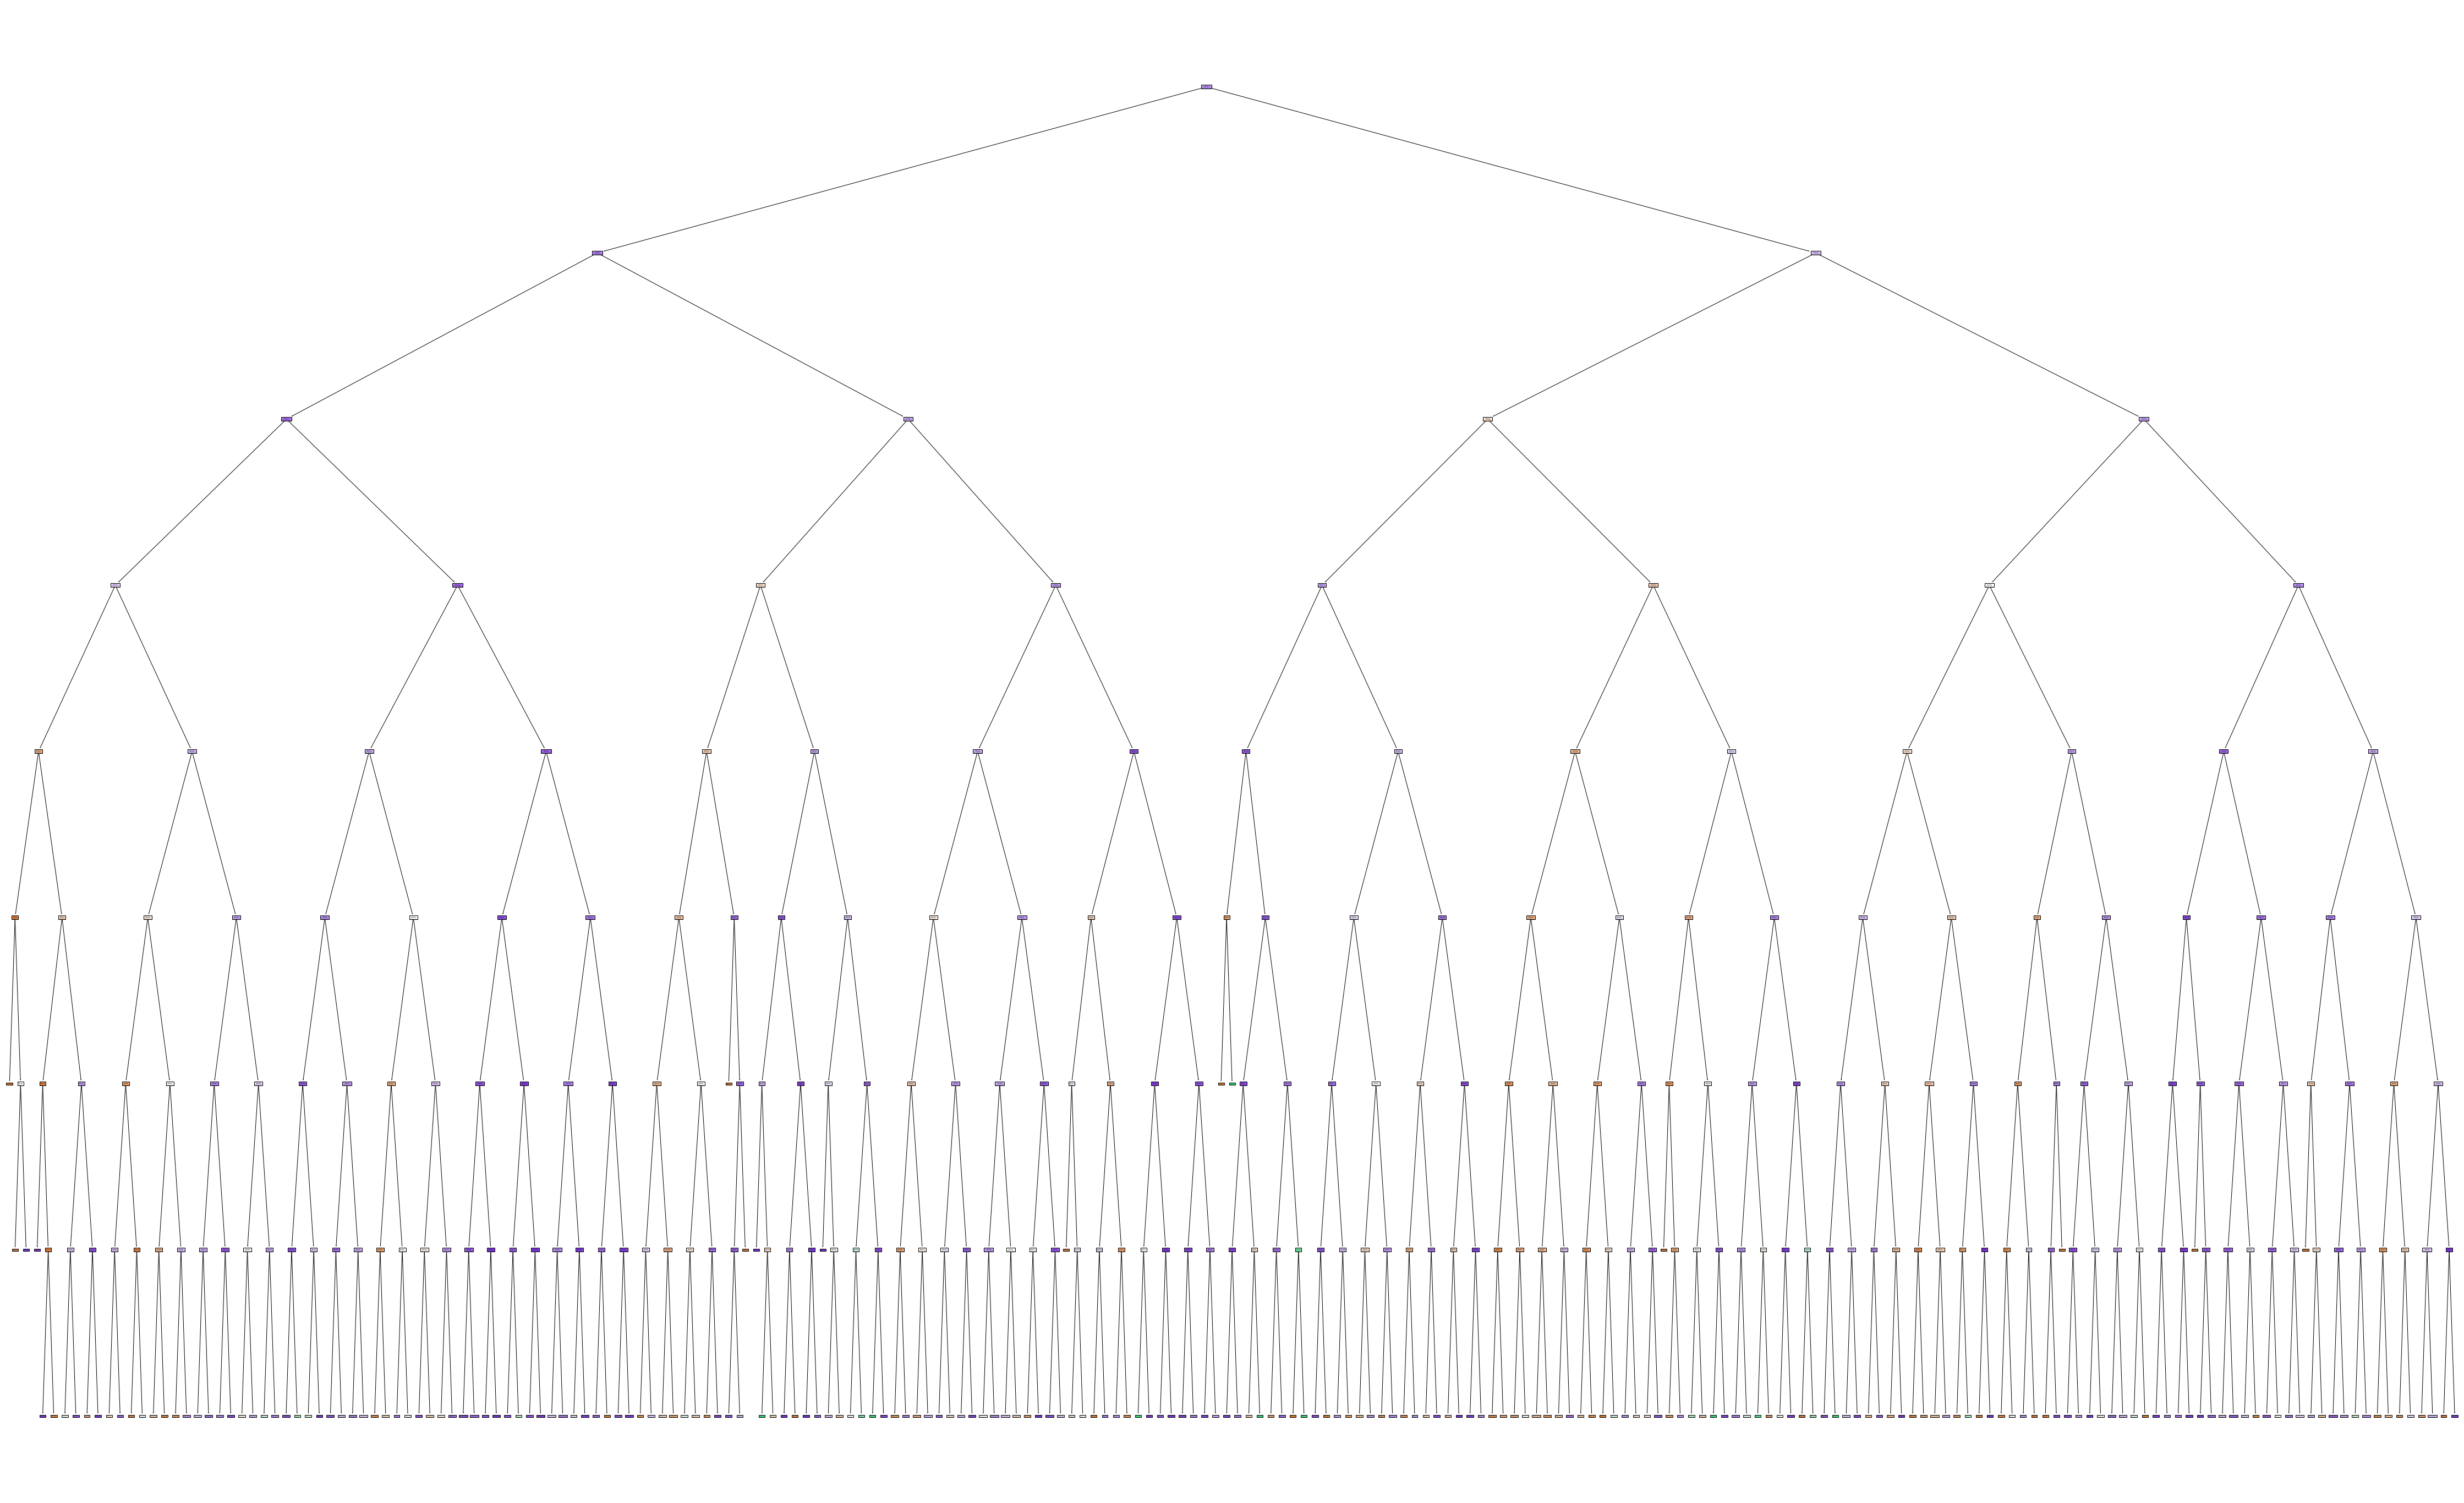

In [14]:
plt.figure(figsize=(80,50))
_ = tree.plot_tree(estimator.best_estimator_, filled=True)

Kako ni ovo nije poboljšalo moć modela, možemo da probamo i ansambl pristup, tj da koristimo šumu.

In [24]:
forest_5 = RandomForestClassifier(n_estimators=5)
forest_5.fit(X_train, y_train.values.ravel())


RandomForestClassifier(n_estimators=5)

In [25]:
report(forest_5, X_test, y_test, "test")

Klasifikacioni izveštaj za model RandomForestClassifier za test podatke
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

          -1       0.68      0.72      0.70      3341
           0       0.34      0.21      0.26      1295
           1       0.86      0.89      0.87      8876

    accuracy                           0.78     13512
   macro avg       0.63      0.61      0.61     13512
weighted avg       0.77      0.78      0.77     13512

---------------------------------------------------------------------------------
Matrica konfuzije za model RandomForestClassifierza test podatke
---------------------------------------------------------------------------------
       0    1    -1
0   2406  229   706
1    435  275   585
-1   689  304  7883
---------------------------------------------------------------------------------


Vidimo da je 5 drveta malo poboljšalo kvalitet modela, pa možemo da pokušamo da povećamo broj njih. 

In [26]:
forest_500 = RandomForestClassifier(n_estimators=500, random_state=42)
forest_500.fit(X_train, y_train.values.ravel())
report(forest_500, X_train, y_train)
report(forest_500, X_test, y_test, "test")

Klasifikacioni izveštaj za model RandomForestClassifier za trening podatke
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     13294
           0       1.00      1.00      1.00      5154
           1       1.00      1.00      1.00     35597

    accuracy                           1.00     54045
   macro avg       1.00      1.00      1.00     54045
weighted avg       1.00      1.00      1.00     54045

---------------------------------------------------------------------------------
Matrica konfuzije za model RandomForestClassifierza trening podatke
---------------------------------------------------------------------------------
        0     1     -1
0   13294     0      0
1       0  5154      0
-1      0     0  35597
---------------------------------------------------------------------------------
Klasifikacioni izveštaj za model RandomForestClassifier 

Kada koristimo 500 drveta, preciznost modela postaje prihvatljiva, ali po cenu interpretabilnosti i vizualizacije.

In [27]:
def auc_score_ovr(y_test, y_pred, c):
    roc_auc_ovr = {}
    # Gets the class
    y_test_array = y_test['Class'].values

    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test_array]
    df_aux['pred'] = y_pred
    df_aux = df_aux.reset_index(drop = True)

    tpr, fpr, _ = roc_curve(df_aux['class'], df_aux['pred'])

    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['pred']) 
    avg_roc_auc = 0  
    i = 0  
    for k in roc_auc_ovr:  
        avg_roc_auc += roc_auc_ovr[k]  
        i += 1  
    return avg_roc_auc/i, tpr, fpr 
    

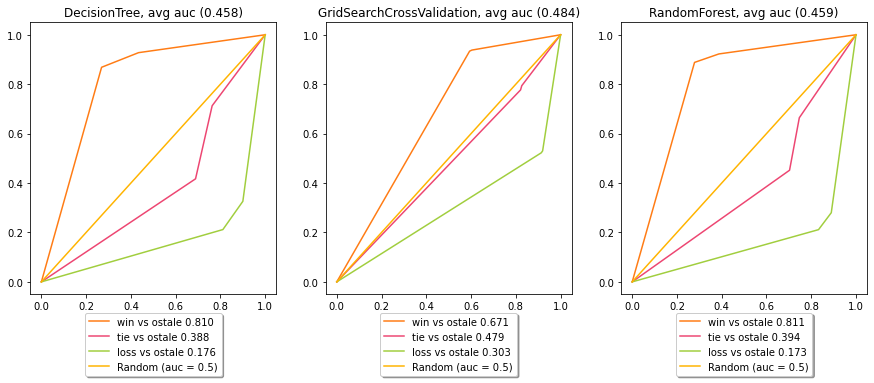

In [28]:
models = [clf, estimator.best_estimator_, forest_5]
names = ['DecisionTree', 'GridSearchCrossValidation', 'RandomForest']
classes = [(1, 'win'), (0, 'tie'), (-1, 'loss')]
comb = zip(models, names)
my_colors=['#FFB400', '#FF7C15', '#ED4672', '#A1CE3E', '#162802']
fig, plots = plt.subplots(1, 3, layout=None,figsize=(15, 5))
i = 0
for model, name in comb:
    y_pred = model.predict(X_test)
#     falsePR, truePR, _ = roc_curve(y_test, y_pred, pos_label=1)
    auc_sum = 0
    j = 1
    for c, n in classes:
        auc, falsePR, truePR = auc_score_ovr(y_test, y_pred, c)
        auc_sum += auc
        label = f'{n} vs ostale {auc:.3f}' 
        plots[i].plot(falsePR, truePR, label=label, color=my_colors[j])
        j += 1
    plots[i].plot([0,1], [0,1], label='Random (auc = 0.5)', color=my_colors[0])
    plots[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=1)
    plots[i].set_title(f'{name}, avg auc ({auc_sum/3:.3f})')
    i += 1